# Testing GOAT
Pranav Mathur

In [1]:
import numpy as np
from numpy.polynomial import chebyshev
import matplotlib.pyplot as plt
from goat_optimization import run_goat_optimization
from qutip_gate_simulation import data_from_tstep, simulate_gate
from scipy.optimize import NonlinearConstraint

## Rydberg Gates

In [2]:
# define hamiltonians
H0 = np.zeros((4, 4))

H_plus = np.array([[0, 0, 1/2, 0],
                   [0, 0, 0, np.sqrt(2)/2],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])
H_minus = np.array([[0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [1/2, 0, 0, 0],
                    [0, np.sqrt(2)/2, 0, 0]])
H_controls = [H_plus, H_minus]

U_target = np.array([[1, 0],
                     [0, -1]])

In [3]:
# define control functions
def to_control_func_plus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(1j * alpha[j])

def to_control_func_minus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])

def to_control_param_derivs(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    deriv_matrix[0][j] = 1j * control_extra_params["Omega_max"] * np.exp(1j * alpha[j])
    deriv_matrix[1][j] = -1j * control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])
    return deriv_matrix

def chebyshev_control_func_plus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( 1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_func_minus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( -1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_param_derivs(t, alpha, control_extra_params=None):
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    phase = chebyshev.chebval((2/control_extra_params["t_max"])*t-1, alpha)
    plus_exp_val = 1j * control_extra_params["Omega_max"] * np.exp(1j * phase)
    minus_exp_val = -1j * control_extra_params["Omega_max"] * np.exp(-1j * phase)
    for i in range(alpha.size):
        c = np.zeros(alpha.size)
        c[i] = 1
        deriv_matrix[0][i] = plus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
        deriv_matrix[1][i] = minus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
    return deriv_matrix

# control_funcs = [to_control_func_plus, to_control_func_minus]
# control_param_derivs = to_control_param_derivs
control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

def U_truncator(U_full):
    if U_full.ndim == 2:
        return U_full[0:2, 0:2]
    else:
        return U_full[:, 0:2, 0:2]

In [4]:
# initial values of piecewise controls
def load_pulse_profile_from_csv(filename):
    gate_parameters = np.genfromtxt(filename, delimiter=',', skip_header=1, filling_values=np.nan)
    t_min = gate_parameters[0, 0]
    t_max = gate_parameters[-2, 0]
    t_steps = gate_parameters[:-1, 0]
    drive_strengths = gate_parameters[:-1, 1]
    phases = gate_parameters[:-1, 2]

    return t_min, t_max, t_steps, drive_strengths, phases

t_min, t_max, t_steps, drive_strengths, phases = load_pulse_profile_from_csv("./pulses/01_cz.csv")
t_span = [t_min, t_max]
n_pieces = phases.size
alpha0 = np.concatenate((phases, [0]))

# custom initial values

# t_max = 7.612 # from TO gates paper
# n_pieces = 100
# t_span = [0, t_max]

# # alpha0 = np.random.uniform(low=np.pi/2, high=(3/2)*np.pi, size=n_pieces+1)
# alpha0 = 0.3 * np.ones(n_pieces + 1) 
# # alpha0 = np.zeros(n_pieces + 1)
# # alpha0 = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=n_pieces+1)

# alpha_bounds = np.tile([0, 2*np.pi], (n_pieces + 1, 1)) 
alpha_bounds = np.tile([-np.pi, np.pi], (n_pieces + 1, 1)) 

In [14]:
# initial values of chebyshev controls
t_min = 0
t_max = 7.612 # from TO gates paper TODO: try lower gate time
t_span = [t_min, t_max]

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

In [15]:
# control extra parameters and callback functions
control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max,
    # "n_pieces": n_pieces
}

# approximate maximum of chebyshev series
def chebyshev_max(coeffs):
    N = coeffs.size - 1
    K = 4 * N
    x = np.cos(np.pi * np.arange(K+1) / K) # chebyshev points
    f = chebyshev.chebval(x, coeffs)
    return np.max(f)    
chebyshev_constraint = NonlinearConstraint(chebyshev_max, -np.pi, np.pi)

prev_params = []
def callback(x):
    prev_params.append(np.copy(x))

In [16]:
res = run_goat_optimization(
    H0,
    H_controls,
    control_funcs,
    control_param_derivs,
    alpha0,
    U_target,
    t_span,
    U_truncator,
    # alpha_bounds=alpha_bounds,
    constraints=chebyshev_constraint,
    single_qubit_phase_weights=[1, 2],
    control_extra_params=control_extra_params,
    callback=callback
)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24528D-01    |proj g|=  4.37915D-01

At iterate    1    f=  3.71115D-01    |proj g|=  3.41056D-01

At iterate    2    f=  2.90150D-01    |proj g|=  3.99572D-01

At iterate    3    f=  1.98523D-01    |proj g|=  2.21749D-01

At iterate    4    f=  7.70511D-02    |proj g|=  1.79197D-01

At iterate    5    f=  9.64584D-03    |proj g|=  8.99292D-02

At iterate    6    f=  4.68631D-03    |proj g|=  5.04762D-02

At iterate    7    f=  2.23096D-03    |proj g|=  2.99984D-02

At iterate    8    f=  8.64650D-04    |proj g|=  9.28771D-03

At iterate    9    f=  3.03146D-04    |proj g|=  9.73272D-03

At iterate   10    f=  1.54934D-04    |proj g|=  3.00334D-03

At iterate   11    f=  9.47951D-05    |proj g|=  2.28327D-03

At iterate   12    f=  4.19192D-05    |proj g|=  5.56279D-03

At iterate   13    f=  3.8


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     27     69      2     0     0   3.710D-08   5.474D-09
  F =   5.4736154497803113E-009

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [ ]:
# load previous run data
import pickle

with open("results/goat_run_13.pkl", "rb") as file:
    (loaded_res, loaded_prev_params) = pickle.load(file)

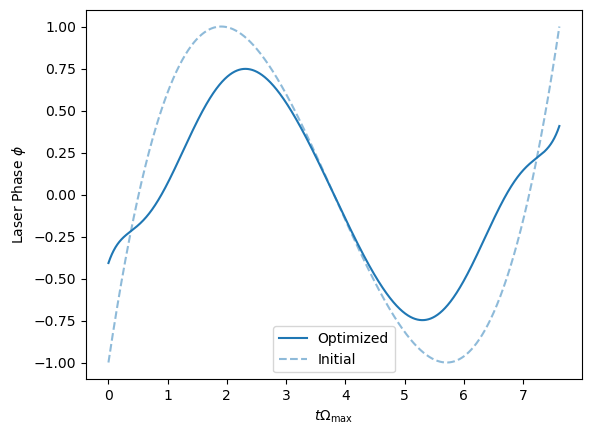

In [17]:
# plot piecewise-continouous gate
# plt.step(np.linspace(0, t_max, n_pieces), res.x[:-1], color="tab:blue", label="Optimized")
# plt.step(np.linspace(0, t_max, n_pieces), alpha0[:-1], alpha=0.35, label="Initial")
# plt.xlabel("$t\\Omega_{\\text{max}}$")
# plt.ylabel("Laser Phase $\\phi$")
# plt.legend()

# plot chebyshev gate
ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, res.x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

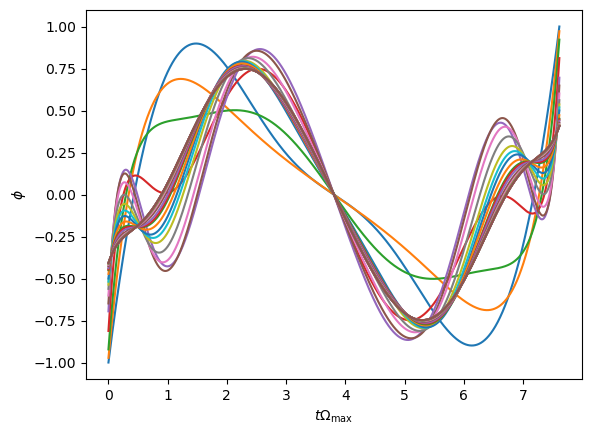

In [18]:
# plot how gate changed during optimization
for i in range(len(prev_params)):
    # plt.step(np.linspace(0, t_max, n_pieces), prev_params[i][:-1], alpha=0.3, label=f"{i}")

    ts = np.linspace(0, t_max, 10001)
    plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, prev_params[i][:-1]))
# plt.step(np.linspace(0, t_max, 100), prev_params[-2][:-1], alpha=0.3) # , label=f"{i}")
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("$\\phi$")
# plt.legend()
plt.show()

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


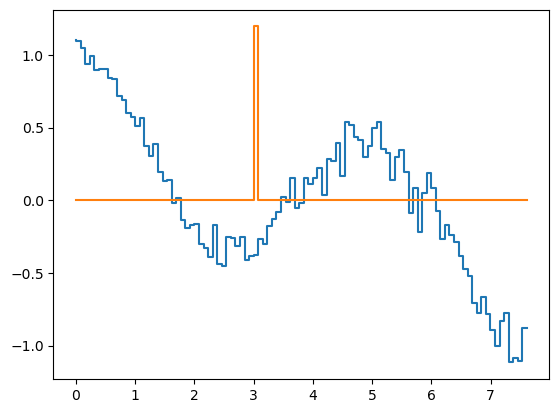

In [6]:
# check that piecewise controls are working
nts = 100
ts = np.linspace(0, t_max, nts)
controls = np.zeros(nts)
control_derivs = np.zeros(nts, dtype=complex)
deriv_j = 40
for i in range(nts):
    cval = to_control_func_plus(ts[i], res.x[:-1], control_extra_params)
    # print(cval)
    controls[i] = np.angle(cval)

    c_derivs = control_param_derivs(ts[i], res.x[:-1], control_extra_params)
    # print(c_derivs)
    control_derivs[i] = np.angle(c_derivs[0][deriv_j])

plt.step(ts, controls)
plt.step(ts, control_derivs)
plt.show()

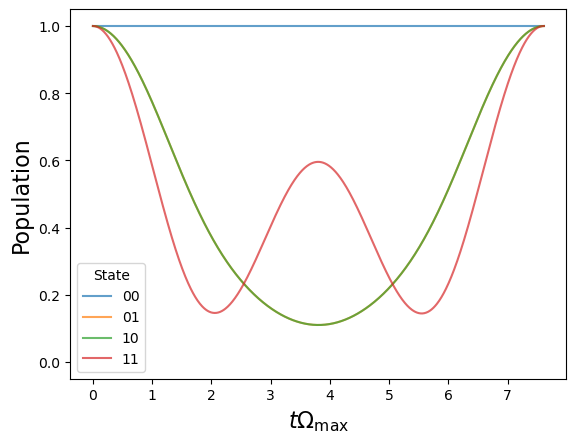

In [19]:
# simulate resulting gate in qutip
to_drive_strength_func = lambda t: 1
to_phase_func = lambda t: data_from_tstep(t, t_steps, res.x[:-1])

chebyshev_drive_strength_func = lambda t: 1
chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, res.x[:-1])

results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001)
# results = simulate_gate(to_drive_strength_func, to_phase_func, 100, 0, t_min, t_max, 1001)
plt.show()

In [31]:
# save results
import pickle

with open("results/goat_run_15.pkl", "wb") as f:
    pickle.dump((res, prev_params), f)

In [ ]:
# exporting to pulse format for qutip simulations
with open("results/goat_run_13.pkl", "rb") as file:
    (loaded_res, loaded_prev_params) = pickle.load(file)

times = np.linspace(0, t_max, n_pieces)
phases = loaded_res.x[:-1]
Omegas = control_extra_params["Omega_max"] * np.ones(n_pieces)


np.savetxt("pulses/goat_gate4_best.csv", np.column_stack((times, Omegas, phases)), delimiter=",", header="t,|Omega|,arg(Omega)")